In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


%load_ext autoreload
%autoreload 2

In [20]:
class AbelianSandpile:
    """
    An Abelian sandpile model simulation. The sandpile is initialized with a random
    number of grains at each lattice site. Then, a single grain is dropped at a random
    location. The sandpile is then allowed to evolve until it is stable. This process
    is repeated n_step times.

    A single step of the simulation consists of two stages: a random sand grain is
    dropped onto the lattice at a random location. Then, a set of avalanches occurs
    causing sandgrains to get redistributed to their neighboring locations.

    Parameters:
    n (int): The size of the grid
    grid (np.ndarray): The grid of the sandpile
    history (list): A list of the sandpile grids at each timestep
    """

    def __init__(self, n=100, random_state=None):
        self.n = n
        np.random.seed(random_state) # Set the random seed
        self.grid = np.random.choice([0, 1, 2, 3], size=(n, n))
        self.history =[self.grid.copy()] # Why did we need to copy the grid?


    def step(self):
        """
        Perform a single step of the sandpile model. Step corresponds a single sandgrain
        addition and the consequent toppling it causes.

        Returns: None
        """
        x,y = np.random.randint(0,self.n, 2)
        self.grid[x,y] += 1

        excess = []
        if self.grid[x,y] >= 4:
          excess.append((x,y))

        while len(excess) > 0:
          x, y = excess.pop()
          self.grid[x,y] -= 4
          if x > 0:
            self.grid[x-1, y] += 1
            if self.grid[x-1, y] >= 4:
              excess.append((x-1, y))

          if x < self.n - 1:
            self.grid[x+1, y] += 1
            if self.grid[x+1, y] >= 4:
              excess.append((x+1, y))

          if y > 0:
            self.grid[x-1, y] += 1
            if self.grid[x, y-1] >= 4:
              excess.append((x, y-1))

          if y < self.n - 1:
            self.grid[x, y+1] += 1
            if self.grid[x, y+1] >= 4:
              excess.append((x, y+1))

    # we use this decorator for class methods that don't require any of the attributes
    # stored in self. Notice how we don't pass self to the method
    @staticmethod
    def check_difference(grid1, grid2):
        """Check the total number of different sites between two grids"""
        return np.sum(grid1 != grid2)

    def simulate(self, n_step):
        """
        Simulate the sandpile model for n_step steps.
        """
        for i in range(n_step):
            self.step()
            if self.check_difference(self.grid, self.history[-1]) > 0:
                self.history.append(self.grid.copy())

        return self.grid


In [21]:
# Check if the "solutions" directory exists. If not, create it and download the solution file
import os
if not os.path.exists('solutions'):
    os.makedirs('solutions')
else:
    print('Directory "solutions" already exists. Skipping creation.')
!wget -P solutions https://raw.githubusercontent.com/williamgilpin/cphy/main/hw/solutions/sandpile.py

Directory "solutions" already exists. Skipping creation.
--2024-09-20 02:16:57--  https://raw.githubusercontent.com/williamgilpin/cphy/main/hw/solutions/sandpile.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11558 (11K) [text/plain]
Saving to: ‘solutions/sandpile.py.4’

sandpile.py.4       100%[===================>]  11.29K  --.-KB/s    in 0s      

2024-09-20 02:16:57 (75.8 MB/s) - ‘solutions/sandpile.py.4’ saved [11558/11558]



Text(0.5, 1.0, 'Avalanche activity in most recent timesteps')

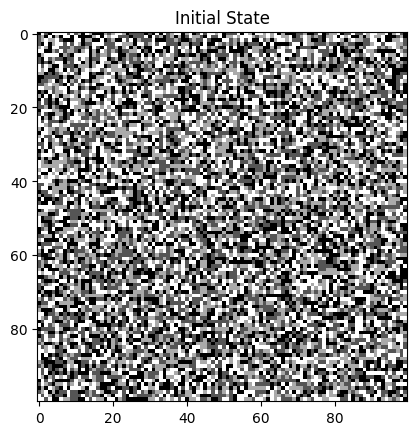

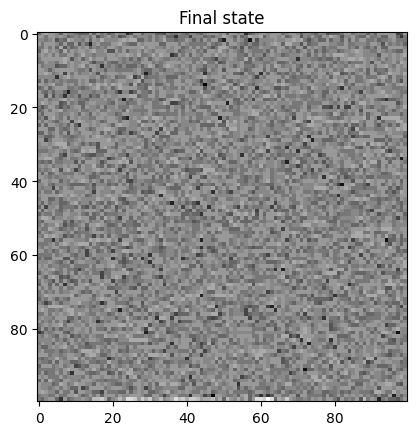

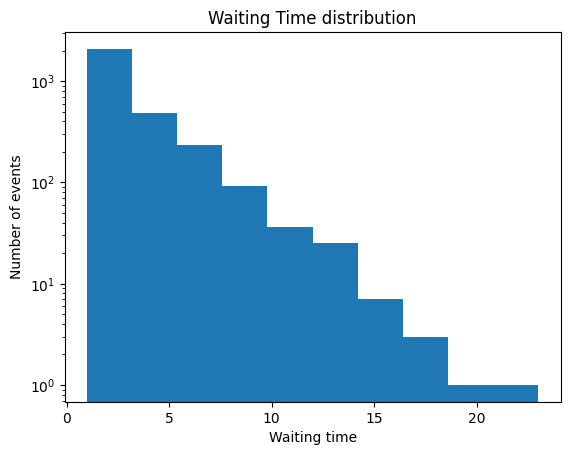

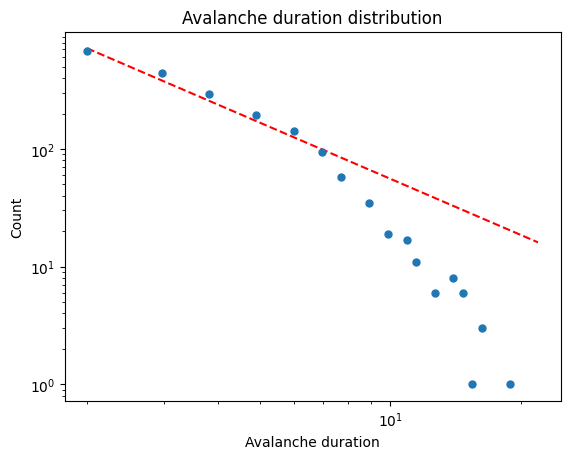

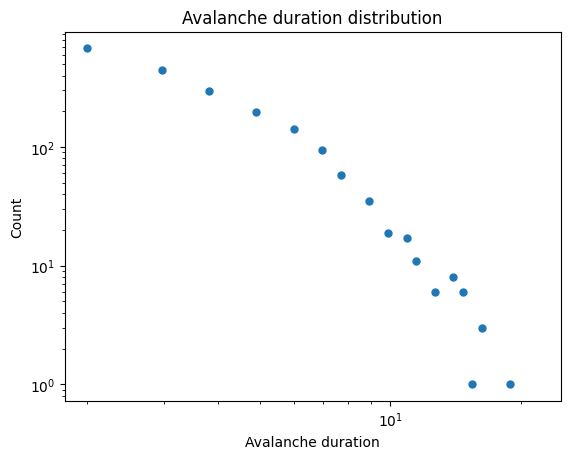

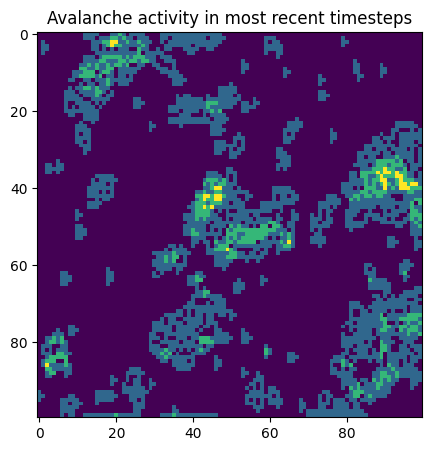

In [26]:
# @title Default title text
## Import William's solution from answer key
# from solutions.sandpile import AbelianSandpileIterative as AbelianSandpile
# from solutions.sandpile import AbelianSandpileBFS as AbelianSandpile
# from solutions.sandpile import AbelianSandpileDFS as AbelianSandpile
from scipy.optimize import curve_fit


# Run sandpile simulation
model = AbelianSandpile(n=100, random_state=0)

plt.figure()
plt.imshow(model.grid, cmap='gray')
plt.title("Initial State")

model.simulate(10000)
plt.figure()
plt.imshow(model.grid, cmap='gray')
plt.title("Final state")




# Compute the pairwise difference between all observed snapshots. This command uses list
# comprehension, a zip generator, and argument unpacking in order to perform this task
# concisely.
all_events =  [model.check_difference(*states) for states in zip(model.history[:-1], model.history[1:])]
# remove transients before the self-organized critical state is reached
all_events = all_events[1000:]
# index each timestep by timepoint
all_events = list(enumerate(all_events))
# remove cases where an avalanche did not occur
all_avalanches = [x for x in all_events if x[1] > 1]
all_avalanche_times = [item[0] for item in all_avalanches]
all_avalanche_sizes = [item[1] for item in all_avalanches]
all_avalanche_durations = [event1 - event0 for event0, event1 in zip(all_avalanche_times[:-1], all_avalanche_times[1:])]


## Waiting time distribution
waiting_times = np.diff(np.array(all_avalanche_times))
plt.figure()
plt.semilogy()
plt.hist(waiting_times)
plt.title('Waiting Time distribution')
plt.xlabel('Waiting time')
plt.ylabel('Number of events')

## Duration distribution
log_bins = np.logspace(np.log10(2), np.log10(np.max(all_avalanche_durations)), 50) # logarithmic bins for histogram
vals, bins = np.histogram(all_avalanche_durations, bins=log_bins)

# Fit a power law to the data
# Filter out the avalanches with counts less than 1 for each duration
# otherwise the curve fit does not converge
lo_filter = vals > 1
hi_vals = vals[lo_filter]
hi_bins = bins[:-1][lo_filter]

# Power law function
def power_law(x, a, b):
    return a * x**b

# Fit the power law, then plot it with the data
popt, pcov = curve_fit(power_law, hi_bins, hi_vals)

plt.figure()
plt.plot(bins[:-1], power_law(bins[:-1], *popt), 'r--')
plt.loglog(bins[:-1], vals, '.', markersize=10)
plt.title('Avalanche duration distribution')
plt.xlabel('Avalanche duration')
plt.ylabel('Count')


plt.figure()
plt.loglog(bins[:-1], vals, '.', markersize=10)
plt.title('Avalanche duration distribution')
plt.xlabel('Avalanche duration')
plt.ylabel('Count')

## Visualize activity of the avalanches
# Make an array storing all pairwise differences between the lattice at successive
# timepoints
all_diffs = np.abs(np.diff(np.array(model.history), axis=0))
all_diffs[all_diffs > 0] = 1
all_diffs = all_diffs[np.sum(all_diffs, axis=(1, 2)) > 1] # Filter to only keep big events
most_recent_events = np.sum(all_diffs[-100:], axis=0)
plt.figure(figsize=(5, 5))
plt.imshow(most_recent_events)
plt.title("Avalanche activity in most recent timesteps")

In [27]:
# The errors for the parameters
a_err = np.sqrt(np.diag(pcov))[1]
b_err = np.sqrt(np.diag(pcov))[0]

# r2 value for the fit
residuals = hi_vals - power_law(hi_bins, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((hi_vals - np.mean(hi_vals))**2)
r_squared = 1 - (ss_res / ss_tot)
r_squared, popt

(0.9706223034342246, array([ 2.15107238e+03, -1.58684179e+00]))

1. I implemented a depth first search algorithm using stacks to track sites.
2. The avalanche duration distribution exhibits a power law distribution. According to a curve fit the best fit a value is 1.59 (r^2 = 0.9706).
3. Worst runtime is O(N^2) this wouuld occur if every site has 3 grains already. The memory usage would ever be O(N) with N sites.
4. Avalanches make the grid more uniform. This would cause avalanches to take longer to occur.

### Extra  code for animations
+ No need to run this, but this code allows you to visualize the sandpile as it evolves over time.

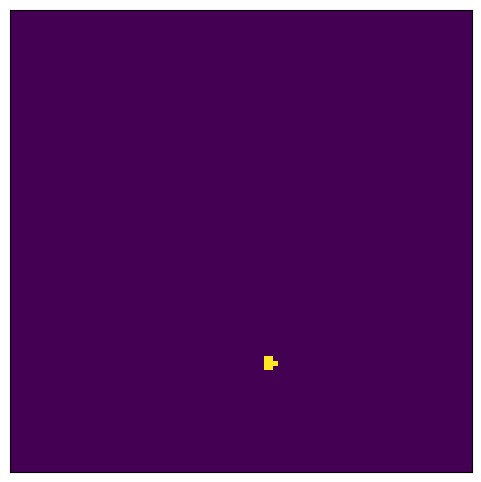

In [23]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

activity_sliding2 = all_diffs[-500:]
vmin = np.percentile(activity_sliding2, 1)
# vmin = 0
vmax = np.percentile(activity_sliding2, 99.8)

# Assuming frames is a numpy array with shape (num_frames, height, width)
frames = np.array(activity_sliding2).copy()

fig = plt.figure(figsize=(6, 6))
img = plt.imshow(frames[0], vmin=vmin, vmax=vmax);
plt.xticks([]); plt.yticks([])
# tight margins
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())

def update(frame):
    img.set_array(frame)

ani = FuncAnimation(fig, update, frames=frames, interval=50)
HTML(ani.to_jshtml())

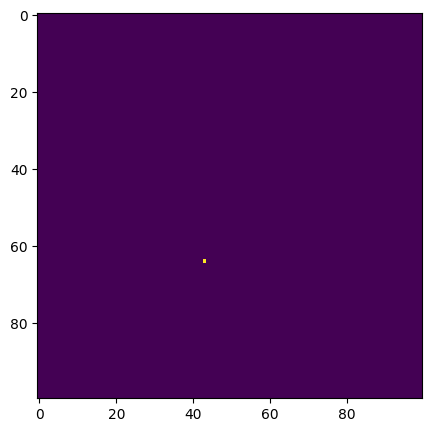

In [24]:
all_diffs = np.abs(np.diff(np.array(model.history), axis=0))
# all_diffs = all_diffs[np.sum(all_diffs, axis=(1, 2)) > 1] # Filter to only keep big events

# Use a trick to calculate the sliding cumulative sum
activity_cumulative = np.cumsum(all_diffs, axis=0)
# activity_sliding = activity_cumulative[50:] - activity_cumulative[:-50]
activity_sliding = all_diffs

plt.figure(figsize=(5, 5))
plt.imshow(activity_sliding[-1])

In [ ]:
# This code saves the sliding cumulative sum as a movie. No need to run this cell

activity_sliding2 = activity_sliding[-500:]
vmin = np.percentile(activity_sliding2, 1)
# vmin = 0
vmax = np.percentile(activity_sliding2, 99.8)
for i in range(len(activity_sliding2) - 1):

    out_path = "private_dump/sandpile/frame" + str(i).zfill(4) + ".png"

    plt.figure()
    plt.imshow(activity_sliding2[i], vmin=vmin, vmax=vmax)

    ax = plt.gca()
    ax.set_axis_off()
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.set_aspect(1, adjustable='box')

    plt.savefig(out_path, bbox_inches='tight', pad_inches=0.0, dpi=300)
    plt.close()



# Percolation

The BTK cellular automaton represents a great example of a simple, toy computational model that exhibits non-trivial properties found in other, much more elaborate problems. It can be considered a [dynamical universality class](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.72.1690), meaning that many problems map onto it, independently of their microscopic details.

Here, we will consider a well-known example of a universality class describing a nonequilibrium phase transition: the directed percolation problem. This problem is usually attributed to [Broadbent & Hammersley in 1957](https://www.cambridge.org/core/journals/mathematical-proceedings-of-the-cambridge-philosophical-society/article/percolation-processes/C00CC4943F48228F8AC8031092FE84EC).

The basic idea is deceptively simple: given a D-dimensional lattice (for our purposes, a 2D grid), we randomly mark sites as "blocked" with probability $p$. The remaining sites are "open" for water to flow. For a given value of $p$, what is the probability that water poured into the top of the lattice will percolate to the bottom row through a chain of connected open sites? This problem is *directed percolation* because it has a preferred direction (water flows from top to bottom). We will assume two open sites are connected if one is north, south, east, or west of the other---but *not* diagonal. This corresponds to [von Neumann neighborhood rules](https://en.wikipedia.org/wiki/Von_Neumann_neighborhood).

A percolation simulation should take a binary array, and return True if it percolates, and False if it does not. There are many ways to implement a percolation algorithm, most of which involve simulating the addition of water to the grid.
+ *Iterative Solution.* One option would be start with the top row, mark all open sites as "filled," and then pass to the next row and search for open sites connected to filled sites. Some addtional care is required, however, because water can pass through channels within a row until it reaches sites that are not directly below filled sites. One workaround would be to perform multiple iterative passes until the filled lattice stops changing. Another edge case is the case where water needs to pass through an uphill channel in order to make it to the bottom---this can be solved by passing over the lattice first from top to bottom, and then vice versa.
+ *Depth-first search (DFS).* Another simulation option would be a depth-first-search, where we start from each site on the top row and we search for any chain of North/Sout/East/West hops that leads to the other side of the lattice, marking all visited sites as filled with water. This last methods demonstrates the conceptual simularity between directed percolation and solving a maze puzzle; the only difference that the "blocked" sites in a maze are non-random.

Here we are going to implemented a directed percolation model, and then perform experiments with it in order to determine how the percolation probability depends on the fraction of blocked sites $p$.

## To Do

1. Implement a two dimensional directed percolation model in Python. I've included my code outline below.
    + The iterative solution simulates water pouring into the top row, and then iterate over rows and sites. With this solution, there is some difficulty regarding how to handle the case where water can flow through a channel from right to left, even though we normally iterate from left to right. This can be solved by passing over each row twice. However, there is also a the case where water needs to pass uphill through a channel before it can proceed downhill. This can be solved by passing over the lattice from top to bottom, and then vice versa.
    + Can you think of a faster way of solving this problem? (Hint: we may not have seen recursion in class yet, but it may be helpful). If you want to try implementing your solution, you will need to add an additional private method `_flow_recursive(i, j)` that contains the recursive logic
2. Perform replicate simulations using the code I've provided below, and create a plot showing how the probability of percolation changes as a function of $p$ (the blockage probability). Beyond seeing the percolation to clogging transition, you'll notice that the variance in the outcome of your simulations behaves unexpectedly. What is going on here? (Hint: If you've studied the Ising model, you've seen something like this before)
3. Theoretically, does the transition point seen in our empirical results align with your intuition? Why does its value differ from $p=0.5$? (Hint: think about sites versus connections between sites).
4. How does the memory usage and runtime of your percolation model implement scale with the lattice size? You can answer this empirically or theoretically.
5. One way to sweep the control parameter $p$ would be to start in a limit where most of the sites are blocked, and then gradually open up individual sites one at a time until the lattice percolates. A video of a simulation where the lattice is gradually opened can be seen [here](https://vimeo.com/747772333). How do the different events in this gradually unblocked percolation simulation relate to the two timescales we saw in the sandpile problem?

In [84]:
class PercolationSimulation:

    def __init__(self, n=100, p=0.5, grid=None, random_state=None):
        self.random_state = random_state # the random seed

        if grid is None:
            self.n = n
            self.p = p
            self.grid = np.zeros((n, n))
            self._initialize_grid()
        else:
            assert len(np.unique(np.ravel(grid))) <= 2, "Grid must only contain 0s and 1s"
            self.grid = grid.astype(int)
            # override numbers if grid is provided
            self.n = grid.shape[0]
            self.p = 1 - np.mean(grid)


        self.grid_filled = np.copy(self.grid)

    def _initialize_grid(self):
        np.random.seed(self.random_state)
        self.grid = np.random.choice([1, 0], size=(self.n, self.n), p=[1 - self.p, self.p])
        self.grid_filled = np.copy(self.grid)


    def _flow_recursive(self, x, y):
        if x < 0 or x >= self.n:
            return None
        if y < 0 or y >= self.n:
            return None
        if self.grid[x, y] == 0:
            return None
        if self.grid_filled[x, y] == 2:
            return None
        self.grid_filled[x, y] = 2
        self._flow_recursive(x + 1, y)
        self._flow_recursive(x - 1, y)
        self._flow_recursive(x, y + 1)
        self._flow_recursive(x, y - 1)

    def percolate(self):
        self._initialize_grid()
        for i in range(1,self.n):
            self._flow_recursive(0,i)
        # return True if any site is full
        return np.any(self.grid_filled[-1] == 2)


### Test and use your code

+ You don't need to write any new code below, these cells are just to confirm that everything is working and to play with the your percolation implementation
+ If you are working from a local fork of the entire course, then you already have access to the solutions. In this case, make sure to `git pull` to make sure that you are up-to-date (save your work first).
+ If you are working from a single downloaded notebook, or are working in Google Colab, then you will need to manually download the solutions file from the course repository. The lines below will do this for you.

In [85]:
# Check if the "solutions" directory exists. If not, create it and download the solution file
import os
if not os.path.exists('solutions'):
    os.makedirs('solutions')
else:
    print('Directory "solutions" already exists. Skipping creation.')
!wget -P solutions https://raw.githubusercontent.com/williamgilpin/cphy/main/hw/solutions/percolation.py

Directory "solutions" already exists. Skipping creation.
--2024-09-20 03:33:38--  https://raw.githubusercontent.com/williamgilpin/cphy/main/hw/solutions/percolation.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9253 (9.0K) [text/plain]
Saving to: ‘solutions/percolation.py.13’

percolation.py.13   100%[===================>]   9.04K  --.-KB/s    in 0s      

2024-09-20 03:33:38 (44.8 MB/s) - ‘solutions/percolation.py.13’ saved [9253/9253]



True
True
False


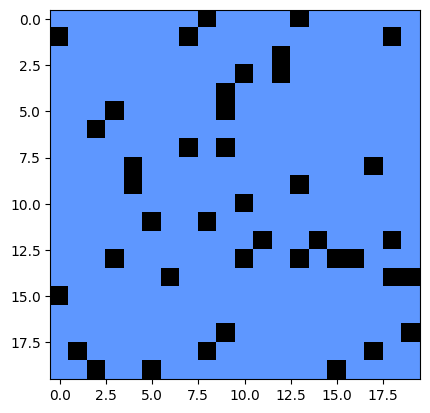

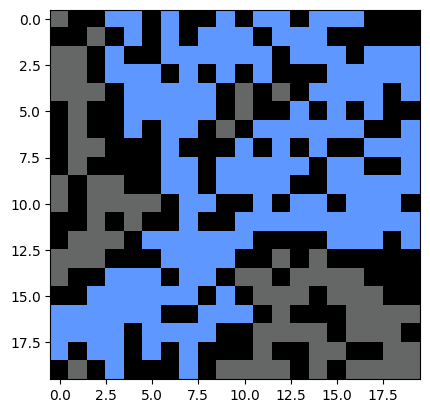

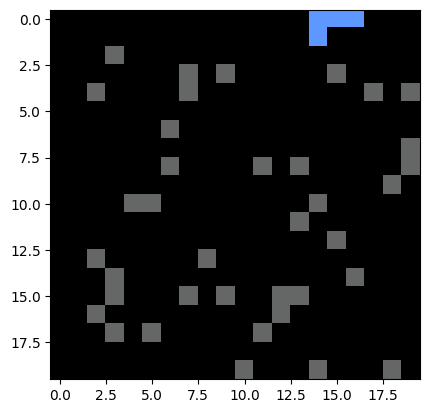

In [86]:
# Import William's solution
# from solutions.percolation import PercolationSimulation
# from solutions.percolation_iterative import PercolationSimulation

from matplotlib.colors import LinearSegmentedColormap
def plot_percolation(mat):
    """
    Plots a percolation matrix, where 0 indicates a blocked site, 1 indicates an empty
    site, and 2 indicates a filled site
    """
    cvals  = [0, 1, 2]
    colors = [(0, 0, 0), (0.4, 0.4, 0.4), (0.372549, 0.596078, 1)]

    norm = plt.Normalize(min(cvals), max(cvals))
    tuples = list(zip(map(norm,cvals), colors))
    cmap = LinearSegmentedColormap.from_list("", tuples)
    plt.imshow(mat, cmap=cmap, vmin=0, vmax=2)


model = PercolationSimulation(n=20, random_state=0, p=0.1)
print(model.percolate())
plt.figure()
plot_percolation(model.grid_filled)

model = PercolationSimulation(n=20, random_state=0, p=0.4)
print(model.percolate())
plt.figure()
plot_percolation(model.grid_filled)


model = PercolationSimulation(n=20, random_state=0, p=0.9)
print(model.percolate())
plt.figure()
plot_percolation(model.grid_filled)

Run replicate simulations across replicates with different bond occupation probabilities

The percolation probability represents an effective order parameter for this system, and
so we will attempt to calculate the percolation probability by performing many replicate
simulations at different values of the control parameter $p$.

Running replicate simulations for p = 0.0
Running replicate simulations for p = 0.041666666666666664
Running replicate simulations for p = 0.08333333333333333
Running replicate simulations for p = 0.125
Running replicate simulations for p = 0.16666666666666666
Running replicate simulations for p = 0.20833333333333331
Running replicate simulations for p = 0.25
Running replicate simulations for p = 0.29166666666666663
Running replicate simulations for p = 0.3333333333333333
Running replicate simulations for p = 0.375
Running replicate simulations for p = 0.41666666666666663
Running replicate simulations for p = 0.4583333333333333
Running replicate simulations for p = 0.5
Running replicate simulations for p = 0.5416666666666666
Running replicate simulations for p = 0.5833333333333333
Running replicate simulations for p = 0.625
Running replicate simulations for p = 0.6666666666666666
Running replicate simulations for p = 0.7083333333333333
Running replicate simulations for p = 0.75
Running

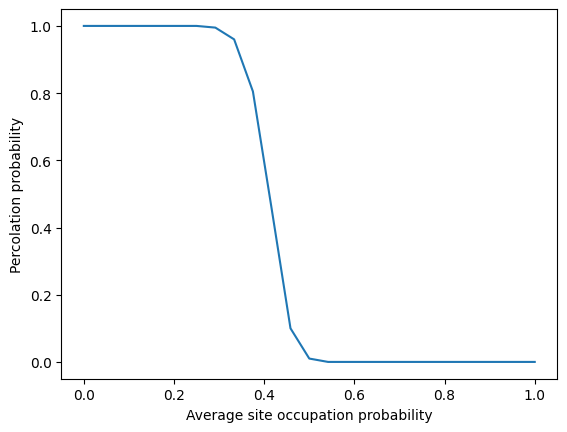

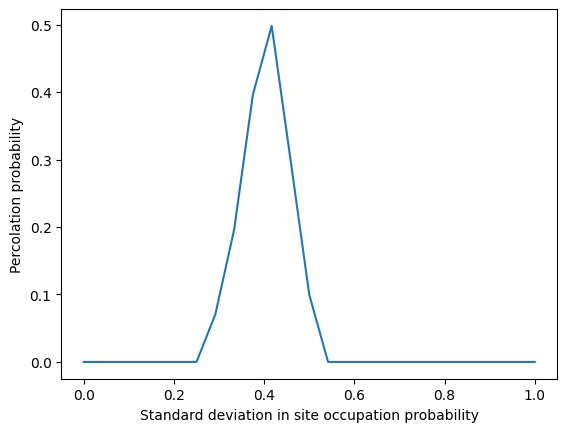

Finished simulation 0


RecursionError: maximum recursion depth exceeded in comparison

In [87]:
# Import William's solution
#from solutions.percolation import PercolationSimulation

pvals = np.linspace(0, 1, 25) # control parameter for percolation phase transition
n_reps = 200 # number of times to repeat the simulation for each p value

all_percolations = list()
for p in pvals:
    print("Running replicate simulations for p = {}".format(p), flush=True)
    all_replicates = list()
    for i in range(n_reps):
        # Initialize the model
        model = PercolationSimulation(30, p=p)
        all_replicates.append(model.percolate())
    all_percolations.append(all_replicates)

plt.figure()
plt.plot(pvals, np.mean(np.array(all_percolations), axis=1))
plt.xlabel('Average site occupation probability')
plt.ylabel('Percolation probability')

plt.figure()
plt.plot(pvals, np.std(np.array(all_percolations), axis=1))
plt.xlabel('Standard deviation in site occupation probability')
plt.ylabel('Percolation probability')

plt.show()


## Just from curiousity, plot the distribution of cluster sizes at the percolation threshold
## why does it appear to be bimodal?
all_cluster_sizes = list()
p_c = 0.407259
n_reps = 5000
for i in range(n_reps):
    model = PercolationSimulation(100, p=p_c)
    model.percolate()
    cluster_size = np.sum(model.grid_filled == 2)
    all_cluster_sizes.append(cluster_size)

    if i % 500 == 0:
        print("Finished simulation {}".format(i), flush=True)

all_cluster_sizes = np.array(all_cluster_sizes)

plt.figure()
plt.hist(all_cluster_sizes, 50);

1. Used a recursive method with boundaries considered and the _flow_recursive method
2. At some probability p the system is difficult to predict given initial conditions.
3. At p=0.5 there is a half blocked situation. we expect that there are 2 blocked connections to another lattice point, and that the probability of percolation to drop off significantly very quickly. So the transition point should be less than p=0.5
4. Runtime is O(sqrt(N) * sqrt(N)/2) while Memory usage should be O(sqrt(N)/2)
5. Most frequent timescales are short percolation events where we remove some points resulting in a few new occupied sites. It may sometimes occur that removing a blocked site will result in a large part of the grid to be filled. These events are similar to the short and long durations in between avalanches in the sandpile model, with the smaller events being more frequent compared to larger events.

## Optional code and extras

Create a simulation where we iteratively fill out one lattice, in order to make a video of our percolation simulation

In [ ]:
initial_lattice = np.zeros((50, 50))

# Decide the order in which sites become blocked
np.random.seed(0)
all_lattice_indices = np.array(
    [(i, j) for i in range(initial_lattice.shape[0]) for j in range(initial_lattice.shape[1])]
)
np.random.shuffle(all_lattice_indices)

# does percolate
all_grids = list()
for inds in all_lattice_indices:

    initial_lattice[inds[0], inds[1]] = 1
    model = PercolationSimulation(grid=initial_lattice)
    model.percolate()

    if (model.p > 0.3) and (model.p < 0.7):
        all_grids.append(np.copy(model.grid_filled))



In [ ]:
## Make an interactive video
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

def plotter(i):
    fig = plt.figure(figsize=(10, 10))
    plot_percolation(all_grids[i])
    plt.show()



interact(
    plotter,
    i=widgets.IntSlider(0, 0, len(all_grids) - 1, layout=Layout(width='500px'))
)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='500px'), max=999), Output()), _…

<function __main__.plotter(i)>

# Appendix and Extras

This is William's leftover code for making videos and figures; no need to run this

TypeError: Invalid shape (500, 50, 50) for image data

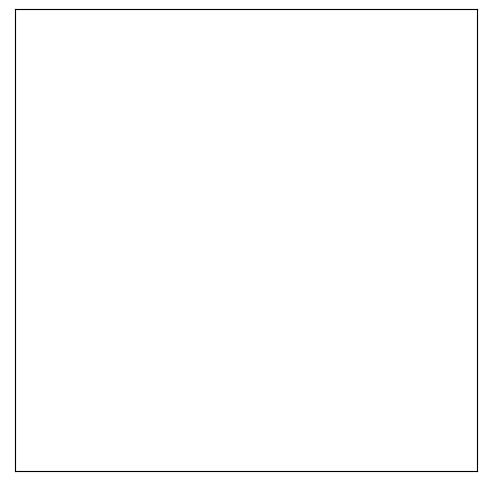

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

activity_sliding2 = activity_sliding[-500:]
vmin = np.percentile(activity_sliding2, 1)
# vmin = 0
vmax = np.percentile(activity_sliding2, 99.8)

# Assuming frames is a numpy array with shape (num_frames, height, width)
frames = np.array(activity_sliding2).copy()

fig = plt.figure(figsize=(6, 6))
# img = plt.imshow(frames[0], vmin=vmin, vmax=vmax);
plt.xticks([]); plt.yticks([])
# tight margins
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())

def update(frame):
    plot_percolation(all_grids[::2])

ani = FuncAnimation(fig, update, frames=all_grids[::2], interval=50)
HTML(ani.to_jshtml())

In [ ]:
# (Optional) I used this code to export still images, and then make a video from them using
# the command-line tool ffmpeg


for i in range(len(all_grids[::2]) - 1):


    out_path = "private_dump/percolation/frame" + str(i).zfill(4) + ".png"

    plt.figure()
    plot_percolation(all_grids[::2][i])

    ax = plt.gca()
    ax.set_axis_off()
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.set_aspect(1, adjustable='box')

    plt.savefig(out_path, bbox_inches='tight', pad_inches=0.0, dpi=160)
    plt.close()



In [ ]:
# (Optional) I used this code to stitch the images together into a video. The %%bash magic tells
# iPython to treat these lines as bash commands, rather than Python. I then use the
# command-line tool `ffmpeg` to stitch the images together into a video.

%%bash
ffmpeg -r 60 -i private_dump/percolation/frame%04d.png -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" -vcodec libx264 -pix_fmt yuv420p private_dump/percolation/vid2.mov


SyntaxError: invalid syntax (1663894352.py, line 6)